# Recommandation

Approche choisie pour créer un système de recommandation : Algorithme de clustering

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import json

Récupère les données des images favorites de l'utilisateur

In [3]:
# Charge les données du fichier JSON
with open("profil.json", "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Extrait les données et les résultats
img_paths = json_data["images"]
data = json_data["data"]
result = json_data["resultats"]

# Crée le DataFrame
data_images = pd.DataFrame(img_paths, columns=["nom_image"])
# Ajoute les colonnes en décomposant les données de "data"
data_expanded = pd.DataFrame(data, columns=["orientation", "qualite", "animal", "nature", "luminosite"])
# Et concatène les deux DataFrames
dataframe = pd.concat([data_images, data_expanded], axis=1)

# Convertit le DataFrame en une liste
given_images = dataframe
given_images = given_images.values.tolist()

# Ajoute la colonne des résultats
dataframe['result'] = result

# Filtre les données pour ne garder que les images favorites
df_favorite = dataframe[dataframe['result'] == 'Favorite']

# Supprime la colonne 'result' après le filtrage
df_favorite = df_favorite.drop(columns=["result"])

# Convertit le DataFrame en une liste
favorite_list = df_favorite.values.tolist()

In [4]:
print("longueur :", len(df_favorite))
print(favorite_list)
print(df_favorite)

longueur : 9
[['77.jpg', 'Paysage', 'moyenne', 'Unknown', 'en nature', 'sombre'], ['86.jpg', 'Paysage', 'moyenne', 'Chien', 'en nature', 'sombre'], ['102.jpg', 'Paysage', 'haute', 'Chien', 'en nature', 'sombre'], ['42.jpg', 'Portrait', 'basse', 'Chien', 'en nature', 'sombre'], ['34.jpg', 'Paysage', 'basse', 'Chien', 'en nature', 'sombre'], ['68.jpg', 'Paysage', 'basse', 'Chien', 'en nature', 'sombre'], ['76.png', 'Portrait', 'moyenne', 'Chien', 'en nature', 'sombre'], ['18.JPG', 'Paysage', 'moyenne', 'Unknown', 'en nature', 'sombre'], ['70.jpg', 'Paysage', 'moyenne', 'Chien', 'en nature', 'sombre']]
   nom_image orientation  qualite   animal     nature luminosite
0     77.jpg     Paysage  moyenne  Unknown  en nature     sombre
1     86.jpg     Paysage  moyenne    Chien  en nature     sombre
4    102.jpg     Paysage    haute    Chien  en nature     sombre
5     42.jpg    Portrait    basse    Chien  en nature     sombre
7     34.jpg     Paysage    basse    Chien  en nature     sombre
9  

Récupère les données de toutes les images existantes et enlève les 20 images proposées à l'utilisateur

In [5]:
# Charge les données du fichier JSON
with open("etiquetage.json", "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Crée le DataFrame
dataframe = pd.DataFrame(json_data, columns=["nom_image", "orientation", "qualite", "animal", "nature", "luminosite"])

# Filtrer les données pour exclure les images spécifiées
dataframe_filtered = dataframe[~dataframe["nom_image"].isin(img_paths)]

# Convertit le DataFrame en une liste
data_list = dataframe.values.tolist()
data_list_filtered = dataframe_filtered.values.tolist()

In [6]:
print("longueur :", len(data_list))
print(data_list)
print("longueur :", len(data_list_filtered))
print(data_list_filtered)
print(dataframe_filtered)

longueur : 116
[['1.jpg', 'Paysage', 'moyenne', 'Chien', 'pas de nature', 'sombre'], ['10.jpg', 'Portrait', 'moyenne', 'Chat', 'en nature', 'lumineux'], ['100.jpg', 'Paysage', 'moyenne', 'Chien', 'pas de nature', 'lumineux'], ['101.png', 'Portrait', 'moyenne', 'Chat', 'pas de nature', 'sombre'], ['102.jpg', 'Paysage', 'haute', 'Chien', 'en nature', 'sombre'], ['103.jpg', 'Paysage', 'basse', 'Chien', 'pas de nature', 'lumineux'], ['104.jpg', 'Paysage', 'haute', 'Chien', 'en nature', 'sombre'], ['105.jpg', 'Paysage', 'moyenne', 'Chien', 'en nature', 'sombre'], ['106.jpg', 'Portrait', 'basse', 'Chat', 'pas de nature', 'sombre'], ['107.jpg', 'Portrait', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['108.jpg', 'Paysage', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['109.jpg', 'Paysage', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['11.jpg', 'Paysage', 'moyenne', 'Chat', 'pas de nature', 'sombre'], ['110.jpg', 'Portrait', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['111.j

In [31]:
# Recommendation function
def recommend_items(cluster, data_with_clusters, given_images):
    # Normalize image names: lowercase, remove spaces, standardize extensions
    data_with_clusters["nom_image"] = (
        data_with_clusters["nom_image"]
        .str.lower()
        .str.strip()
        .str.replace(r'\.jpeg$', '.jpeg', regex=True)
        .str.replace(r'\.jpg$', '.jpg', regex=True)
        .str.replace(r'\.png$', '.png', regex=True)
    )

    # Extract only image names from given_images and normalize them
    given_image_names = [
        img[0].lower().strip()
        for img in given_images
    ]

    # Ensure unique image names
    given_image_names = list(set(given_image_names))

    # Select items from the cluster
    items_in_cluster = data_with_clusters[data_with_clusters["Cluster"] == cluster].copy()

    # Exclude given images from recommendations
    filtered_items = items_in_cluster[~items_in_cluster["nom_image"].isin(given_image_names)]

    if filtered_items.empty:
        return pd.DataFrame()  # Return an empty DataFrame if no items to recommend

    # Sample up to 3 items from the filtered list
    recommended_items = filtered_items.sample(n=min(3, len(filtered_items)))
    return recommended_items

# Encode categorical features
label_encoders = [LabelEncoder() for _ in range(len(data_list[0]))]
encoded_data = []
for i, column in enumerate(zip(*data_list)):
    encoded_data.append(label_encoders[i].fit_transform(column))
X = list(zip(*encoded_data))  # Features

# Clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(X)
clusters = kmeans.labels_

# Add cluster labels to the original data
data_with_clusters = pd.DataFrame(data_list, columns=["nom_image", "orientation", "qualite", "animal", "nature", "luminosite"])
data_with_clusters["Cluster"] = clusters

# Get clusters for each favorite image
clusters = []
for img_fav in favorite_list:
    encoded_interaction = [label_encoders[i].transform([val])[0] for i, val in enumerate(img_fav)]
    cluster = kmeans.predict([encoded_interaction])[0]
    clusters.append(cluster)

# Get 12 recommendations from 4 different clusters
recommendations = pd.DataFrame()
for cluster in set(clusters):  # For each unique favorite cluster
    recs = recommend_items(cluster, data_with_clusters, given_images)
    recommendations = pd.concat([recommendations, recs])

print("Recommended items:")
print(recommendations)

Recommended items:
    nom_image orientation  qualite animal         nature luminosite  Cluster
82     69.jpg     Paysage    haute   Chat  pas de nature     sombre        0
67     55.jpg    Portrait  moyenne   Chat  pas de nature     sombre        0
58     47.jpg     Paysage  moyenne   Chat  pas de nature   lumineux        0
48     38.jpg    Portrait    basse  Chien      en nature     sombre        1
29     20.jpg     Paysage  moyenne  Chien  pas de nature   lumineux        1
31     22.jpg     Paysage    haute   Chat  pas de nature     sombre        1
16    113.jpg     Paysage    haute   Chat      en nature     sombre        2
13    110.jpg    Portrait  moyenne   Chat  pas de nature   lumineux        2
25     17.jpg       Carre  moyenne  Chien      en nature     sombre        2
112    96.jpg    Portrait    basse   Chat  pas de nature   lumineux        3
92    78.jpeg     Paysage    basse   Chat      en nature   lumineux        3
97     82.jpg     Paysage    haute   Chat  pas de nature 

Affichage des images recommandées

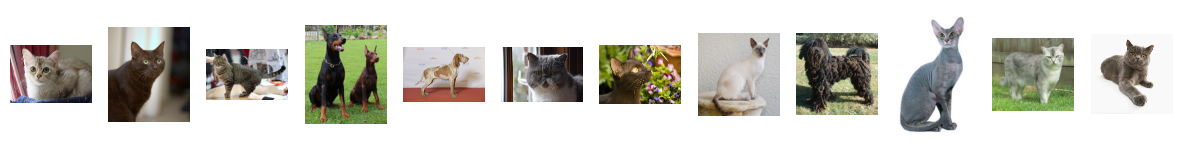

In [32]:
# Extract the image paths from the "nom_image" column
recommended_img = recommendations["nom_image"].tolist()

# Create a figure with a grid of subplots
fig, axes = plt.subplots(1, len(recommended_img), figsize=(15, 5))

# If there is only one image
if len(recommended_img) == 1:
    axes = [axes]

# Display each image in the grid
for ax, path in zip(axes, recommended_img):
    img = mpimg.imread("images/" + path)
    ax.imshow(img)
    ax.axis('off')  # Remove the axes

plt.show()  # Display the grid of images